%%capture hides cell output

This example illustrates the use of a causal model and causal inference methods to estimate the effect of `study hours` (per week) in the final exam `scores`. Our outcome again is students' scores. We aim to estimate the causal effect that the "*treatment*" `study hours` has on students' `scores` (effect). Our beliefs and assumptions are encoded into a causal model. We assume that `study hours` (per week) is directly related to `scores` but also that the `prior knowledge` affects both the effect and the cause (i.e., it is a confounder). For this exercise we will employ Python language and the library [doWhy](https://www.pywhy.org).

Three variables:

- Study hours
- Prior Knowledge
- Exam score

Assumptions: 

- Study hours relate with Exam score.
- Prior knowledge affects both the study hours and exam score.

This example shows how to estimate the effect while controlling for the confounder. Remember that a confounder `Z` affects both the cause `X` and the effect (outcome) `Y`.

In [12]:
%%capture
%pip install dowhy matplotlib

In [21]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import dowhy
from dowhy import CausalModel

## Generate synthetic data

Then, we begin by creating a synthetic dataset in which study hours and prior knowledge are random variables normally distributed. Then, exam score is a function of both study hours and prior knowledge. In a real world scenario, we would normally not know about this function because is what we are trying to estimate. Note the values in the function, specifically, the `2 * data["study_hours"]`.


In [68]:
# Generate a synthetic dataset
np.random.seed(42)
data = pd.DataFrame({
    "study_hours": np.random.normal(10, 2, 1000),  # Study hours per week
    "prior_knowledge": np.random.normal(3, 1, 1000),  # Prior knowledge level
    "exam_score": np.zeros(1000)  # Placeholder for exam score
})

# Define the relationship: Exam score is influenced by both study hours and prior knowledge
data["exam_score"] = 5 + 2 * data["study_hours"] + 5 * data["prior_knowledge"] + np.random.normal(0, 1, 1000) 

In [69]:
data.tail(15)

,study_hours,prior_knowledge,exam_score
985,7.683271,3.513085,36.971922
986,13.006797,3.725096,49.516363
987,11.754725,3.516178,46.183713
988,9.558072,2.358518,34.778532
989,10.053772,3.431923,44.678833
990,10.416766,3.800410,46.351973
991,5.916530,3.754291,36.206635
992,9.505645,4.188913,45.027894
993,8.636032,3.708304,40.601373
994,7.996760,3.351448,36.798843


## Create causal model
Now, we will define the model and visualize it. 

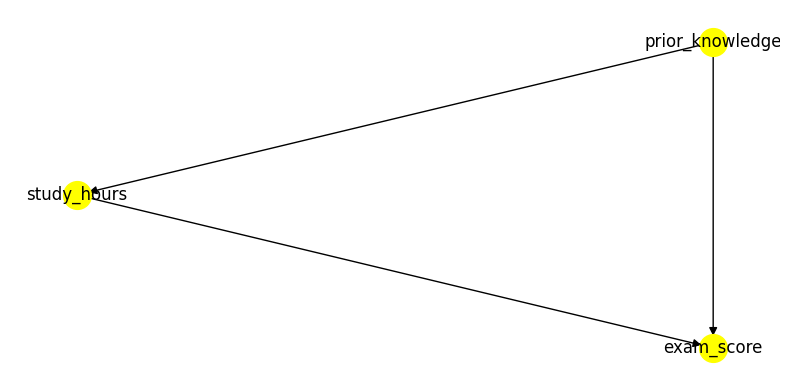

In [73]:
# Causal inference model setup
model = CausalModel(
    data=data,
    treatment="study_hours",
    outcome="exam_score",
    common_causes=["prior_knowledge"]
)

# Visualize the causal graph
model.view_model(layout="dot", size=(8,4))
plt.tight_layout(w_pad=1)


## Calculate the estimate

The backdoor criterion is a method used in causal inference to control for confounders—variables that influence both the treatment and the outcome. By satisfying the backdoor criterion, we aim to isolate the causal effect of the treatment on the outcome by “blocking” other paths of influence.

This adjustment is typically done in one of a few statistical ways, such as conditioning, stratification, or regression.

In [74]:
%%capture
# Identifying and estimating the causal effect
identified_estimand = model.identify_effect()
estimate = model.estimate_effect(identified_estimand, method_name="backdoor.linear_regression")

In [75]:
# Show results
print("Causal Estimate of Study Hours on Exam Score:", estimate.value)

Causal Estimate of Study Hours on Exam Score: 2.010902911319441


This means that, according to our initial causal model, an additional hour of study per week is estimated to increase the exam score by approximately 2 points. 

This effect is derived after accounting for the confounder (in this case, prior knowledge) using the backdoor criterion.

If this estimate is accurate, it suggests a positive causal relationship between study hours and exam score, where more study hours lead to higher scores.

In [76]:
%%capture
# Refutation: placebo test to check robustness of the result
refute_result = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter", verbose=0)

In [77]:
print(refute_result)

Refute: Use a Placebo Treatment
Estimated effect:2.010902911319441
New effect:0.0
p value:2.0



The placebo test helps us check if this estimated causal effect could be due to biases in the model rather than a true causal relationship.

Here, the test has replaced the actual treatment (study_hours) with a "placebo" or random variable that should have no causal effect on the outcome (exam_score).

- New effect (0.0): This shows that the placebo treatment has no effect on the outcome, as expected (since it’s a random variable unrelated to exam score).

- Original effect (2.01) vs. New effect (0.0): The fact that the original effect remains 2.01 while the placebo effect is 0 suggests that the observed causal effect of study hours on exam score is not due to random bias. Instead, it’s likely a true effect.

- p-value (2.0): A high p-value indicates that there is no statistically significant effect with the placebo treatment. This further supports that any observed effect in the placebo scenario is likely due to chance.

The placebo test confirms that our causal model appears robust, as it detects no effect when a placebo treatment is used. Therefore, we can have more confidence that the estimated effect of 2.01 is a genuine causal effect of study hours on exam score, rather than an artifact of model bias or unmeasured confounding.

These results suggest that our initial model is likely valid, meaning that the relationship we estimated is trustworthy given the data and assumptions.






